In [17]:
import os, sys
import numpy as np
import pandas as pd
from typing import Dict

In [18]:
print(os.getcwd())

/home/mila/teaching/user09


In [19]:
path_to_images = "/home/mila/teaching/user09/new_data/Train/Image/"
path_to_profile = "/home/mila/teaching/user09/new_data/Train/Profile/"
path_to_text = "/home/mila/teaching/user09/new_data/Train/Text/"

sys.path.append(path_to_images)
sys.path.append(path_to_profile)
sys.path.append(path_to_text)

print(sys.path)

['/home/mila/teaching/user09', '/home/mila/teaching/user09/.conda/envs/fb-env/lib/python37.zip', '/home/mila/teaching/user09/.conda/envs/fb-env/lib/python3.7', '/home/mila/teaching/user09/.conda/envs/fb-env/lib/python3.7/lib-dynload', '', '/home/mila/teaching/user09/.conda/envs/fb-env/lib/python3.7/site-packages', '/home/mila/teaching/user09/.conda/envs/fb-env/lib/python3.7/site-packages/IPython/extensions', '/home/mila/teaching/user09/.ipython', '/home/mila/teaching/user09/new_data/Train/Image/', '/home/mila/teaching/user09/new_data/Train/Profile/', '/home/mila/teaching/user09/new_data/Train/Text/', '/home/mila/teaching/user09/new_data/Train/Image/', '/home/mila/teaching/user09/new_data/Train/Profile/', '/home/mila/teaching/user09/new_data/Train/Text/']


### I. Set up dataframe with original features

In [4]:
img_df = pd.read_csv(path_to_images + "oxford.csv")
profile_df = pd.read_csv(path_to_profile + "Profile.csv")

In [5]:
img_df.head(n=1)

,userId,faceID,faceRectangle_width,faceRectangle_height,faceRectangle_left,faceRectangle_top,pupilLeft_x,pupilLeft_y,pupilRight_x,pupilRight_y,...,underLipTop_x,underLipTop_y,underLipBottom_x,underLipBottom_y,facialHair_mustache,facialHair_beard,facialHair_sideburns,headPose_roll,headPose_yaw,headPose_pitch
0,0000e06e07496624211632e8e264126c,f7e072db-8532-4686-9074-27e83fee5e94,61,61,15,49,32.7,64.7,59.7,65.0,...,41.8,94.3,41.9,98.6,0.0,0.0,0.0,3.9,-22.4,0.0


In [6]:
def extract_gender(df: pd.Series) -> int:
    return profile_df[profile_df["userid"] == df['userId']]["gender"].item()

In [7]:
genders = [extract_gender(row[1]) for row in img_df.iterrows()]

/home/mila/teaching/user09/.conda/envs/fb-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### II. Set up functions for experiments

In [8]:
from sklearn.model_selection import validation_curve

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

In [10]:
Data = namedtuple("Data", ['X', 'y'])
NAVY = "#001f3f"


def experiment(estimator, preprocessed_train, hyper_parameter_name, hyper_parameter_values, x_axis_label):
    train_scores, valid_scores = validation_curve(estimator,
                                                  preprocessed_train.X,
                                                  preprocessed_train.y,
                                                  hyper_parameter_name,
                                                  hyper_parameter_values,
                                                  cv=4,
                                                  verbose=3,
                                                  n_jobs=3,
                                                  scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.title("Validation Curve with xgboost for gender classification")
    plt.xlabel(x_axis_label)
    plt.ylabel("Accuracy")
    lw = 2

    plt.plot(hyper_parameter_values, train_scores_mean, label="Training Accuracy",
                 color="darkorange", lw=lw)
    plt.fill_between(hyper_parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(hyper_parameter_values, valid_scores_mean, label="Cross-Validation Accuracy",
                 color=NAVY, lw=lw)
    plt.fill_between(hyper_parameter_values, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color=NAVY, lw=lw)
    print("Training Accuracy:", train_scores)
    print("Valid Accuracy:", valid_scores)
    plt.legend(loc="best")
    plt.show()

### III. Experiments with original features

In [11]:
img_df = img_df.assign(gender=genders)

In [12]:
features, labels = img_df.drop(["userId", "faceID", "gender"], axis=1), img_df["gender"]

In [13]:
training_data = Data(X=features.values, y=labels.values)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   7 out of  24 | elapsed:    4.7s remaining:   11.3s
[Parallel(n_jobs=3)]: Done  16 out of  24 | elapsed:    9.2s remaining:    4.6s


Training Accuracy: [[0.86840775 0.8731469  0.8733367  0.8762001 ]
 [0.86908172 0.87348383 0.87434731 0.8762001 ]
 [0.87379949 0.87769542 0.8756948  0.88024255]
 [0.88104465 0.88258086 0.88310595 0.88512717]
 [0.88744735 0.89033019 0.89001179 0.89085397]
 [0.89283909 0.89487871 0.89506485 0.8967492 ]]
Valid Accuracy: [[0.88232323 0.86558868 0.87512639 0.86046512]
 [0.88181818 0.86508338 0.87563195 0.86097068]
 [0.88080808 0.86609399 0.87563195 0.86299292]
 [0.88131313 0.86255685 0.87411527 0.86046512]
 [0.88080808 0.86255685 0.87007078 0.85692619]
 [0.88131313 0.86205154 0.87007078 0.85793731]]


[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:   14.8s finished


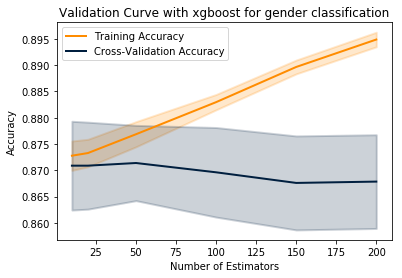

In [14]:
# Experiment 1: CV on Number of Boosting Stages.

from xgboost import XGBClassifier
experiment(XGBClassifier(max_depth=3, learning_rate=0.1),
           training_data,
           "n_estimators",
           [10, 20, 50, 100, 150, 200],
           "Number of Estimators")

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  12 | elapsed:    2.4s remaining:    7.3s
[Parallel(n_jobs=3)]: Done   8 out of  12 | elapsed:    4.0s remaining:    2.0s


Training Accuracy: [[0.8673968  0.87230458 0.86929426 0.87451575]
 [0.87379949 0.87769542 0.8756948  0.88024255]
 [0.89772536 0.89706873 0.89472798 0.89826512]]
Valid Accuracy: [[0.88131313 0.86457807 0.87360971 0.85389282]
 [0.88080808 0.86609399 0.87563195 0.86299292]
 [0.88080808 0.86659929 0.87462083 0.85692619]]


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    6.0s finished


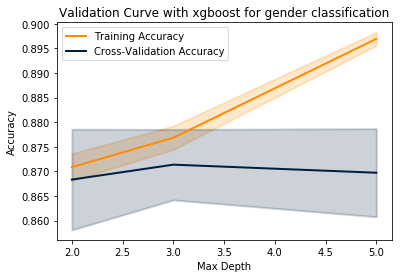

In [15]:
# Experiment 2: CV on Max Depth.

experiment(XGBClassifier(n_estimators=50),
           training_data,
           "max_depth",
           [2, 3, 5],
           "Max Depth")

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  12 | elapsed:    2.1s remaining:    6.2s
[Parallel(n_jobs=3)]: Done   8 out of  12 | elapsed:    3.8s remaining:    1.9s


Training Accuracy: [[0.87379949 0.87769542 0.8756948  0.88024255]
 [0.86722831 0.87264151 0.87215766 0.87636854]
 [0.86655434 0.87264151 0.87215766 0.87653697]]
Valid Accuracy: [[0.88080808 0.86609399 0.87563195 0.86299292]
 [0.88181818 0.86407276 0.87563195 0.85995956]
 [0.88333333 0.86407276 0.87411527 0.86046512]]


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    4.7s finished


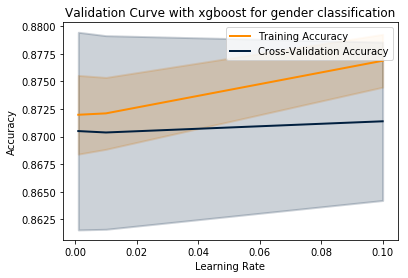

In [16]:
# Experiment 3: CV on the Learning Rate.

experiment(XGBClassifier(n_estimators=50, max_depth=3),
           training_data,
           "learning_rate",
           [0.1, 0.01, 0.001],
           "Learning Rate")

### IV. Experiments with engineered features

#### function to calculate the euclidean distance between 2 points

In [20]:
def euclidean_dist(a, b):
    
    """
    calculates the euclidean distance between 2 points
    """
    
    assert a.shape == b.shape, "a and b must have the same shape"
    
    return np.sqrt(((a-b) ** (2)).sum(axis=0))

In [21]:
img_df_new = img_df.assign(pupilLeftRight = lambda x: euclidean_dist(np.array([img_df['pupilLeft_x'], img_df['pupilLeft_y']]),
                                                                 np.array([img_df['pupilRight_x'], img_df['pupilRight_y']])), 
                       mouthLeftRight = lambda x: euclidean_dist(np.array([img_df['mouthLeft_x'], img_df['mouthLeft_y']]),
                                                                 np.array([img_df['mouthRight_x'], img_df['mouthRight_y']])),
                       eyebrowLeftRightOuter = lambda x: euclidean_dist(np.array([img_df['eyebrowLeftOuter_x'], img_df['eyebrowLeftOuter_y']]),
                                                                        np.array([img_df['eyebrowRightOuter_x'], img_df['eyebrowRightOuter_y']])),
                       eyebrowLeftRightInner = lambda x: euclidean_dist(np.array([img_df['eyebrowLeftInner_x'], img_df['eyebrowLeftInner_y']]),
                                                                        np.array([img_df['eyebrowRightInner_x'], img_df['eyebrowRightInner_y']])),                       
                       eyeLeftRightOuter = lambda x: euclidean_dist(np.array([img_df['eyeLeftOuter_x'], img_df['eyeLeftOuter_y']]),
                                                                    np.array([img_df['eyeRightOuter_x'], img_df['eyeRightOuter_y']])),
                       eyeLeftRightInner = lambda x: euclidean_dist(np.array([img_df['eyeLeftInner_x'], img_df['eyeLeftInner_y']]),
                                                                    np.array([img_df['eyeRightInner_x'], img_df['eyeRightInner_y']])),
                       eyeLeftTopBottom = lambda x: euclidean_dist(np.array([img_df['eyeLeftTop_x'], img_df['eyeLeftTop_y']]),
                                                                   np.array([img_df['eyeLeftBottom_x'], img_df['eyeLeftBottom_y']])),
                       eyeRightTopBottom = lambda x: euclidean_dist(np.array([img_df['eyeRightTop_x'], img_df['eyeRightTop_y']]),
                                                                    np.array([img_df['eyeRightBottom_x'], img_df['eyeRightBottom_y']])),
                       noseRootLeftRight = lambda x: euclidean_dist(np.array([img_df['noseRootLeft_x'], img_df['noseRootLeft_y']]),
                                                                    np.array([img_df['noseRootRight_x'], img_df['noseRootRight_y']])),
                       noseLeftRightAlarTop = lambda x: euclidean_dist(np.array([img_df['noseLeftAlarTop_x'], img_df['noseLeftAlarTop_y']]),
                                                                       np.array([img_df['noseRightAlarTop_x'], img_df['noseRightAlarTop_y']])),
                       noseLeftRightAlarOutTip = lambda x: euclidean_dist(np.array([img_df['noseLeftAlarOutTip_x'], img_df['noseLeftAlarOutTip_y']]),
                                                                          np.array([img_df['noseRightAlarOutTip_x'], img_df['noseRightAlarOutTip_x']])),
                       upperLipTopBottom = lambda x: euclidean_dist(np.array([img_df['upperLipTop_x'], img_df['upperLipTop_y']]),
                                                                    np.array([img_df['upperLipBottom_x'], img_df['upperLipBottom_y']])),
                       underLipTopBottom = lambda x: euclidean_dist(np.array([img_df['underLipTop_x'], img_df['underLipTop_y']]),
                                                                    np.array([img_df['underLipBottom_x'], img_df['underLipBottom_y']])))


#### Check for duplicates, make a function to take the faceID that has a greater faceRectangle area

In [22]:
img_df_new = img_df_new.assign(faceRectangle_area = lambda x: img_df_new['faceRectangle_width'] * img_df_new['faceRectangle_height'])
img_df_new = img_df_new.assign(gender = genders)

img_df_new.head(n=2)

,userId,faceID,faceRectangle_width,faceRectangle_height,faceRectangle_left,faceRectangle_top,pupilLeft_x,pupilLeft_y,pupilRight_x,pupilRight_y,...,eyeLeftRightOuter,eyeLeftRightInner,eyeLeftTopBottom,eyeRightTopBottom,noseRootLeftRight,noseLeftRightAlarTop,noseLeftRightAlarOutTip,upperLipTopBottom,underLipTopBottom,faceRectangle_area
0,0000e06e07496624211632e8e264126c,f7e072db-8532-4686-9074-27e83fee5e94,61,61,15,49,32.7,64.7,59.7,65.0,...,38.125713,17.301156,5.178803,4.401136,8.000625,12.110326,34.609247,3.014963,4.301163,3721
1,000235a2ba2f48231b7d24e1f08d7878,934b5179-acec-4dea-a348-feae87767c2d,83,83,91,95,114.4,117.6,154.5,121.0,...,51.056929,27.894982,2.236068,3.106445,12.946814,15.404220,26.224607,4.304649,5.115662,6889


In [23]:
duplicates = img_df_new[img_df_new.duplicated(['userId'])]

for userid in duplicates['userId']:
    
    df = img_df_new[img_df_new['userId'] == userid]
    faceID_used = df[df['faceRectangle_area'] == df['faceRectangle_area'].max()]["faceID"]
    img_df_new = img_df_new[img_df_new['faceID'] != faceID_used.values[0]]   

duplicates = img_df_new[img_df_new.duplicated(['userId'])]
duplicates.head(n=4)

,userId,faceID,faceRectangle_width,faceRectangle_height,faceRectangle_left,faceRectangle_top,pupilLeft_x,pupilLeft_y,pupilRight_x,pupilRight_y,...,eyeLeftRightOuter,eyeLeftRightInner,eyeLeftTopBottom,eyeRightTopBottom,noseRootLeftRight,noseLeftRightAlarTop,noseLeftRightAlarOutTip,upperLipTopBottom,underLipTopBottom,faceRectangle_area


#### Don't run this cell if you want to keep the original columns

In [109]:
for column in img_df_new.columns:
    if column[-1] == 'x' or column[-1] == 'y':
        img_df_new = img_df_new.drop(columns = column)
    else:
        continue

In [110]:
print(img_df_new.columns)

Index(['userId', 'faceID', 'faceRectangle_width', 'faceRectangle_height',
       'faceRectangle_left', 'faceRectangle_top', 'facialHair_mustache',
       'facialHair_beard', 'facialHair_sideburns', 'headPose_roll',
       'headPose_yaw', 'headPose_pitch', 'pupilLeftRight', 'mouthLeftRight',
       'eyebrowLeftRightOuter', 'eyebrowLeftRightInner', 'eyeLeftRightOuter',
       'eyeLeftRightInner', 'eyeLeftTopBottom', 'eyeRightTopBottom',
       'noseRootLeftRight', 'noseLeftRightAlarTop', 'noseLeftRightAlarOutTip',
       'upperLipTopBottom', 'underLipTopBottom', 'faceRectangle_area',
       'gender'],
      dtype='object')


In [111]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

img_df_new[img_df_new.columns[2:-1]] = scaler.fit_transform(img_df_new[img_df_new.columns[2:-1]])

img_df_new.head(n=1)

,userId,faceID,faceRectangle_width,faceRectangle_height,faceRectangle_left,faceRectangle_top,facialHair_mustache,facialHair_beard,facialHair_sideburns,headPose_roll,...,eyeLeftRightInner,eyeLeftTopBottom,eyeRightTopBottom,noseRootLeftRight,noseLeftRightAlarTop,noseLeftRightAlarOutTip,upperLipTopBottom,underLipTopBottom,faceRectangle_area,gender
0,0000e06e07496624211632e8e264126c,f7e072db-8532-4686-9074-27e83fee5e94,0.153374,0.138122,0.092025,0.213974,0.0,0.0,0.0,0.593074,...,0.160862,0.264187,0.226682,0.181638,0.15885,0.162411,0.239898,0.244502,0.057894,1.0


In [24]:
features_new, labels_new = img_df_new.drop(["userId", "faceID", "gender"], axis=1), img_df_new["gender"]

In [25]:
training_data_new = Data(X=features_new.values, y=labels_new.values)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   7 out of  24 | elapsed:    5.2s remaining:   12.7s
[Parallel(n_jobs=3)]: Done  16 out of  24 | elapsed:   10.6s remaining:    5.3s
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:   17.2s finished


Training Accuracy: [[0.88864101 0.89351422 0.89035495 0.89574429]
 [0.88919874 0.89277086 0.89109831 0.89555845]
 [0.89087191 0.89555845 0.89332838 0.89778852]
 [0.89700688 0.89927523 0.897231   0.90131946]
 [0.90239822 0.90522208 0.90299201 0.90652295]
 [0.90741774 0.90986805 0.9081955  0.91191228]]
Valid Accuracy: [[0.89972145 0.88733965 0.89737869 0.88064696]
 [0.89972145 0.88733965 0.89793642 0.88120468]
 [0.90139276 0.8884551  0.89682097 0.88064696]
 [0.89916435 0.8884551  0.8951478  0.88064696]
 [0.89805014 0.88622421 0.89459007 0.88064696]
 [0.89637883 0.88455103 0.8951478  0.88008924]]


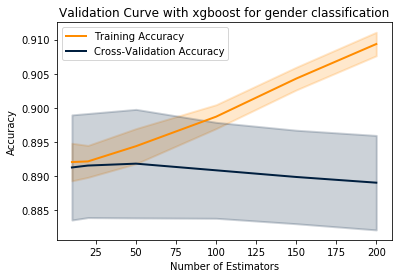

In [26]:
# Experiment 1: CV on Number of Boosting Stages.

from xgboost import XGBClassifier
experiment(XGBClassifier(max_depth=3, learning_rate=0.1),
           training_data_new,
           "n_estimators",
           [10, 20, 50, 100, 150, 200],
           "Number of Estimators")

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  12 | elapsed:    5.9s remaining:   17.7s
[Parallel(n_jobs=3)]: Done   8 out of  12 | elapsed:    7.8s remaining:    3.9s


Training Accuracy: [[0.8884551  0.89258502 0.89072663 0.89500093]
 [0.89087191 0.89555845 0.89332838 0.89778852]
 [0.90630229 0.90838134 0.90931054 0.91116893]]
Valid Accuracy: [[0.89805014 0.88678193 0.89626325 0.88008924]
 [0.90139276 0.8884551  0.89682097 0.88064696]
 [0.89805014 0.88901283 0.89682097 0.87897379]]


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   10.0s finished


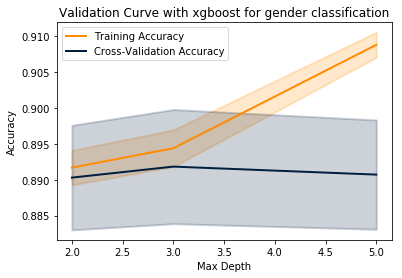

In [27]:
# Experiment 2: CV on Max Depth.

experiment(XGBClassifier(n_estimators=50),
           training_data_new,
           "max_depth",
           [2, 3, 5],
           "Max Depth")

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  12 | elapsed:    2.2s remaining:    6.6s
[Parallel(n_jobs=3)]: Done   8 out of  12 | elapsed:    4.2s remaining:    2.1s


Training Accuracy: [[0.88919874 0.89314254 0.89016911 0.89574429]
 [0.89087191 0.89555845 0.89332838 0.89778852]
 [0.89403235 0.89853187 0.89648764 0.89964691]]
Valid Accuracy: [[0.89972145 0.88733965 0.89737869 0.88064696]
 [0.90139276 0.8884551  0.89682097 0.88064696]
 [0.89916435 0.88789738 0.89682097 0.88120468]]


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    5.2s finished


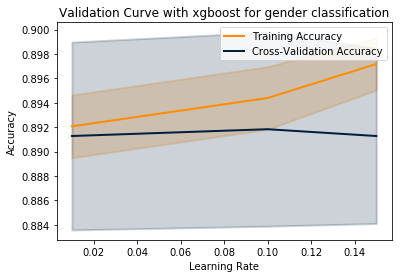

In [28]:
# Experiment 3: CV on the Learning Rate.

experiment(XGBClassifier(n_estimators=50, max_depth=3),
           training_data_new,
           "learning_rate",
           [0.01, 0.1, 0.15],
           "Learning Rate")

### Bayesian optimization

#### accuracy with current hyperparams

In [115]:
estimator = ensemble.GradientBoostingClassifier(learning_rate = 0.1,
                                                n_estimators = 25,
                                                max_depth = 3)

scores = cross_validate(estimator, 
                        training_data_new.X, 
                        training_data_new.y, 
                        cv=4,
                        scoring="accuracy")

In [116]:
print(scores['test_score'].mean())

0.8914109652672806


#### Hyperparam search using hyperopt

In [112]:
from sklearn import ensemble
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_validate

def hyperopt_train_test(params, X_train, y_train):
    
    estimator = ensemble.GradientBoostingClassifier(learning_rate = params['learning_rate'],
                                                    n_estimators = 25,
                                                    max_depth = params['max_depth'])
    
    scores = cross_validate(estimator, 
                            X_train, 
                            y_train, 
                            cv=4,
                            scoring="accuracy")
    
    return scores['test_score'].mean()

In [201]:
def f(params):
    acc = hyperopt_train_test(params, training_data_new.X, training_data_new.y)
    return {'loss': -acc, 'status': STATUS_OK}

space = {
         'n_estimators': hp.choice('n_estimators', [24, 25, 26, 49, 50, 51]),
         #'n_estimators': hp.quniform('n_estimators', 10, 200, 10),
         'max_depth': hp.quniform('max_depth', 1, 5, 1),
         'learning_rate': hp.choice('learning_rate', [0.09, 0.1, 0.11, 0.12, 0.13, 0.14])
         #'learning_rate': hp.loguniform('learning_rate', -0.5, 0.5),   
}


trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=50, trials=trials)
print ('Best: ', best)

print ('Trials:')

for trial in trials.trials:
    print(trial)

100%|██████████| 50/50 [02:21<00:00,  2.84s/it, best loss: -0.8923868277594544]
Best:  {'learning_rate': 5, 'max_depth': 3.0, 'n_estimators': 2}
Trials:
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.8914108099122711, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'max_depth': [0], 'n_estimators': [0]}, 'vals': {'learning_rate': [1], 'max_depth': [4.0], 'n_estimators': [4]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2019, 12, 2, 10, 0, 33, 412000), 'refresh_time': datetime.datetime(2019, 12, 2, 10, 0, 37, 184000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.8898775336460112, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [1], 'max_depth': [1], 'n_estimators': [1]}, 'vals': {'learning_rate': [4], 'max_depth': [5.0], 'n_estimators': [1]}}, 'exp_key': None, 'owne